## Import MIR-1K Dataset

The dataset can be found https://sites.google.com/site/unvoicedsoundseparation/mir-1k

In [32]:
from scipy import signal
from scipy.io import wavfile
import glob, os
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [33]:
songs = []
fs = 10e3
for file in os.listdir('./MIR-1K/Wavfile'):
    if file.endswith('.wav'):
        fs, data = wavfile.read(os.path.join("./MIR-1K/Wavfile",file))
        songs.append(data)

In [34]:

f, t, Zxx = signal.stft(song[0], fs)


/Users/jaemincheun/anaconda3/lib/python3.6/site-packages/scipy/signal/spectral.py:1773: UserWarning: nperseg = 256 is greater than input length  = 2, using nperseg = 2
  .format(nperseg, input_length))


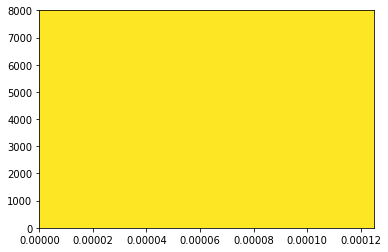

In [39]:
plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=9)